6h30min audio at 48 kHz + RMVPE pitch extraction = 16.1 GiB disk space

log data point every 200 steps, save ckpt every 5 epoch

batch size = 8 ⇒ 1 epoch = 1053 steps

train locally, ≈ 10.5 minute/epoch

train 300 epochs, select ckpt at 160th epoch

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

In [ ]:
mydf = pd.read_csv("data_tensorboard_RVC.csv")
mydf.head()
mydf.info()
mydf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   step    1595 non-null   int64  
 1   lossG   1595 non-null   float64
 2   lossD   1595 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 37.5 KB


,step,lossG,lossD
count,1595.000000,1595.000000,1595.000000
mean,157663.949843,36.672498,3.432016
std,91040.783521,1.843056,0.165148
min,0.000000,29.995220,2.899924
25%,78700.000000,35.469788,3.317391
50%,157400.000000,36.548111,3.431742
75%,236100.000000,37.722481,3.543648
max,315800.000000,56.310791,3.999995


In [ ]:
def smooth(array: np.ndarray, weight: float = .9) -> np.ndarray:
	"""
	smooth loss curve like in TensorBoard with exponential moving average
	using 1st order IIR (infinite impulse response) filter
	see https://stackoverflow.com/a/42724386/10805680
	"""
	return lfilter([1. - weight], [1., -weight], array, zi=[array[0]])[0]

mydf["smooth_lossG"] = smooth(mydf["lossG"])
mydf["smooth_lossD"] = smooth(mydf["lossD"])

In [ ]:
colorG, colorD = "red", "blue"
def plot_loss(df: pd.DataFrame, title: str) -> plt.Figure:
	"""plot loss curve for Generator & Discriminator"""

	lossGmin, lossGmax = df["smooth_lossG"].min(), df["smooth_lossG"].max()
	lossDmin, lossDmax = df["smooth_lossD"].min(), df["smooth_lossD"].max()
	coefG = (lossGmax - lossGmin) / 10
	coefD = (lossDmax - lossDmin) / 10

	fig, ax0 = plt.subplots(figsize=(10, 5), layout="tight")
	fig.suptitle(title)

	ax0.set_xlabel("step")
	ax0.xaxis.set_major_formatter(EngFormatter())
	ax0.plot(df["step"], df["lossG"], color=colorG, linestyle="dotted", alpha=.2)
	ax0.plot(df["step"], df["smooth_lossG"], color=colorG, linewidth=.7)
	ax0.set_ylim((lossGmin - coefG, lossGmax + coefG))
	ax0.set_ylabel("Generator loss", color=colorG)
	ax0.tick_params(axis="y", labelcolor=colorG)

	ax1 = ax0.secondary_xaxis("top", functions=(lambda x: x/1053, lambda x: x*1053))  # 1 epoch = 1053 steps
	ax1.set_xlabel("epoch")

	ax2 = ax0.twinx()
	ax2.plot(df["step"], df["lossD"], color=colorD, linestyle="dotted", alpha=.2)
	ax2.plot(df["step"], df["smooth_lossD"], color=colorD, linewidth=.7)
	ax2.set_ylim((lossDmin - coefD, lossDmax + coefD))
	ax2.set_ylabel("Discriminator loss", color=colorD)
	ax2.tick_params(axis="y", labelcolor=colorD)

	return fig  # `fig.show()` raise weird warning
# write `… = plot_loss(…)` to prevent plot printed twice

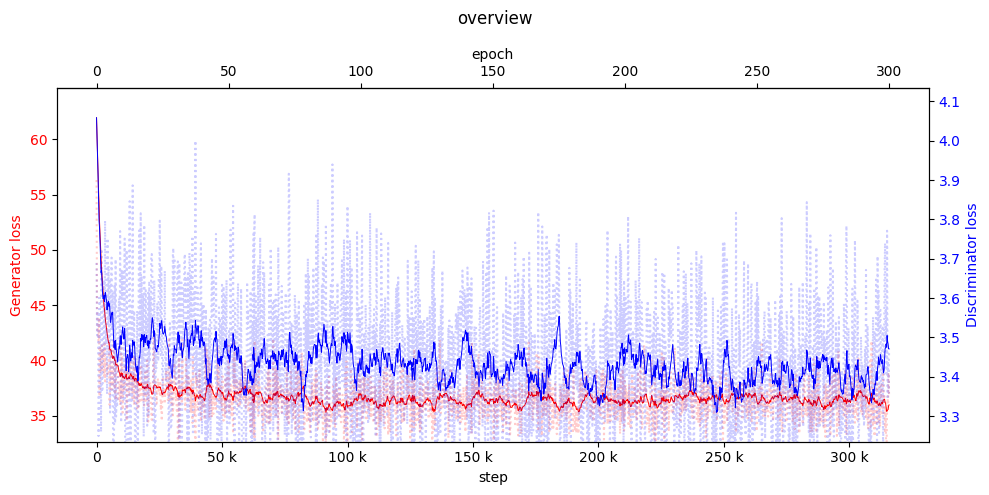

In [ ]:
_ = plot_loss(mydf, "overview")

diagnose loss curve:
- https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic
- https://rentry.org/RVC_making-models (too much oversimplified)

but in reality loss curve for GAN is more complicated to deal with, see https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b
- Non-convergence: network parameters oscillate, destabilize and may never converge
- Mode collapse: the generator produces very limited varieties of samples
- Diminished gradient: the discriminator gets too successful that the generator gradient vanishes and learns nothing
- Unbalance between the generator and discriminator causing overfitting
- Highly sensitive to the hyperparameter selections

D:\myconda\envs\hug\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


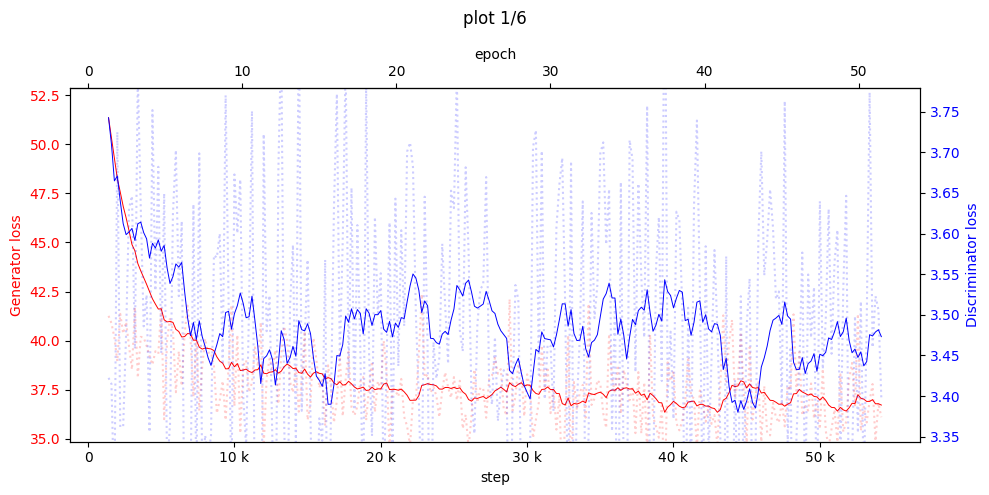

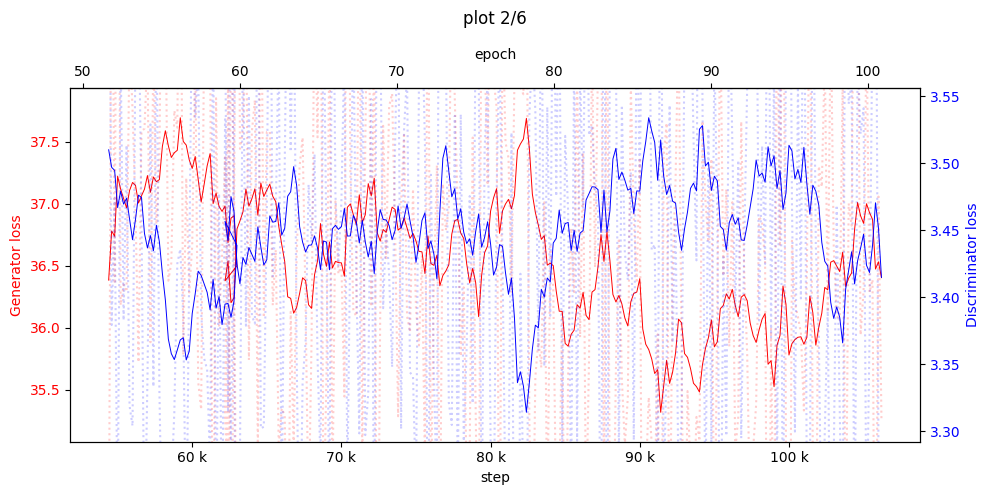

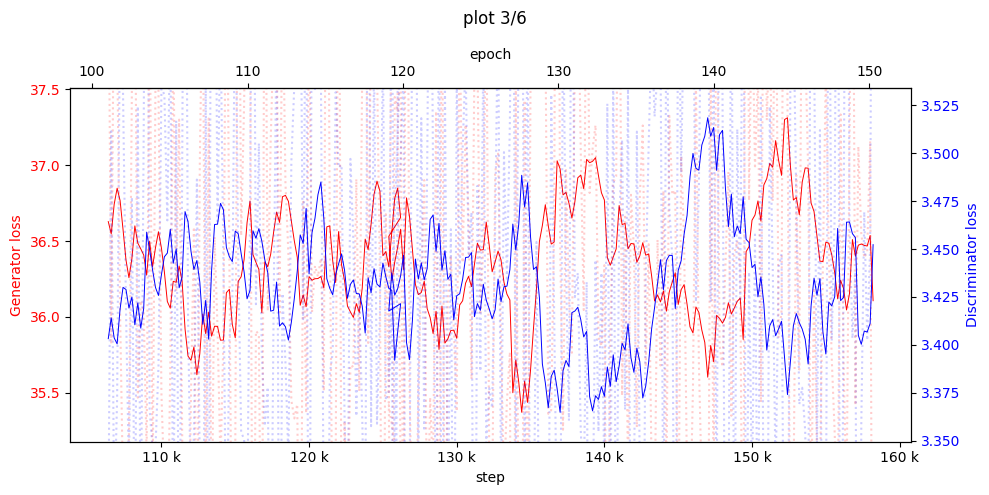

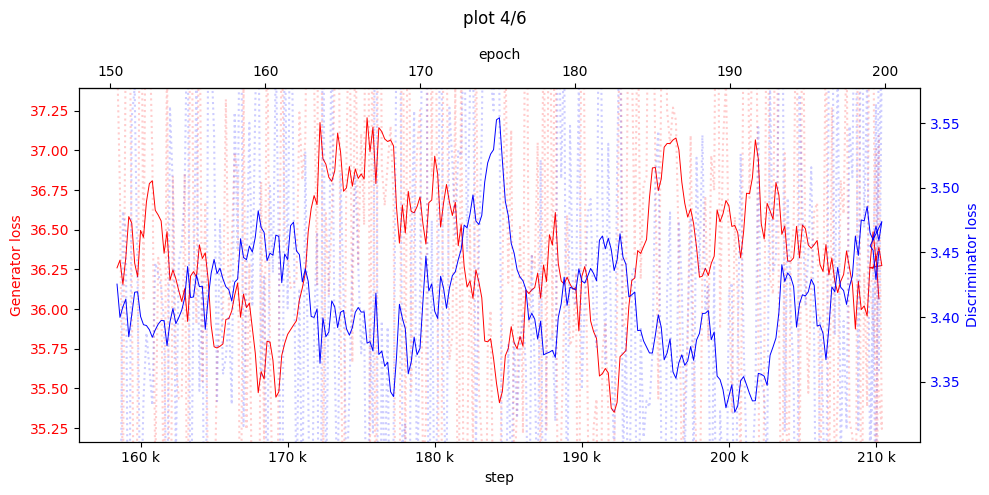

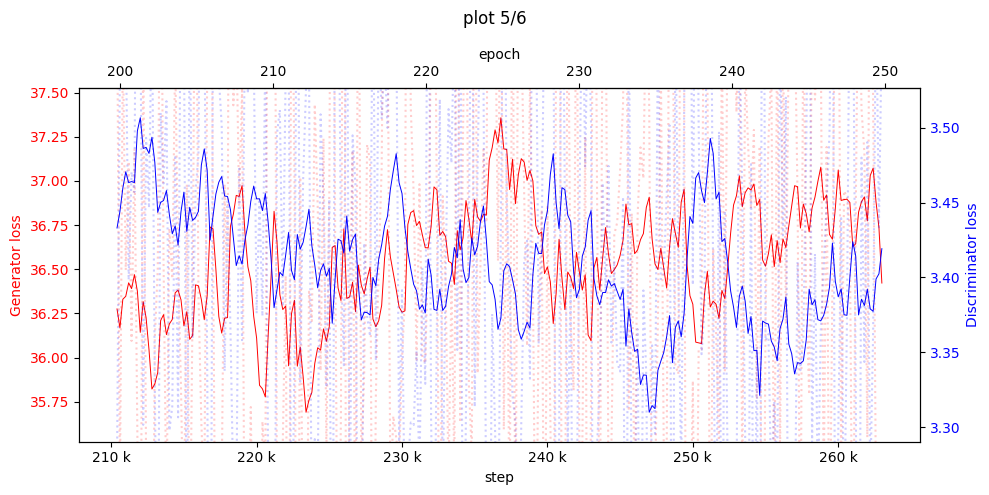

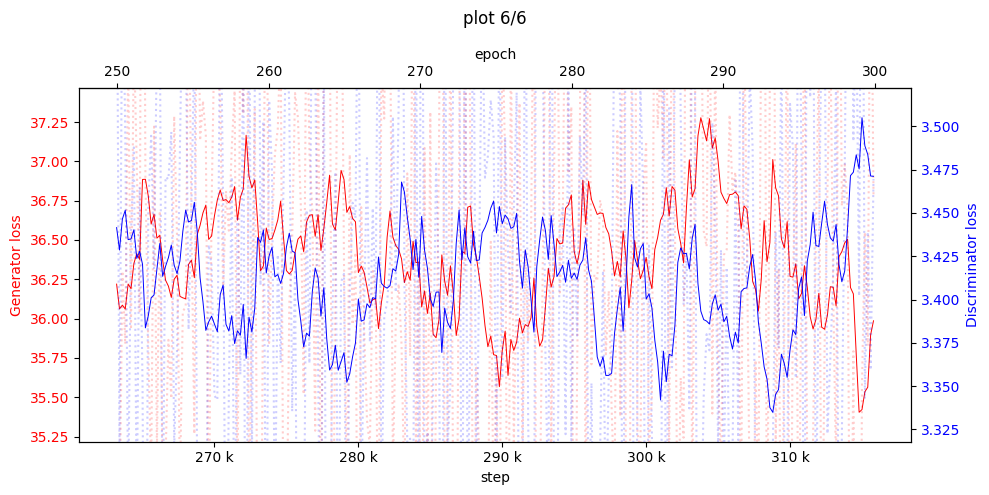

In [ ]:
N_plot = 6
mydf_split = np.array_split(mydf.iloc[7:,:], N_plot)
for i in range(N_plot):
	_ = plot_loss(mydf_split[i], f"plot {i+1}/{N_plot}")